#  MONAI Bootcamp
## End-To-End Workflow with MONAI part 4 ( data partition + Ignite Supervised Evaluator and Trainer)


# same baseline End-to-end Training with Ignite
We've covered a lot of material and now it's time to apply the things that we've learned in an end-to-end example. First, we're going to use the basic PyTorch paradigm for training our model. We'll then look at how to train using the Ignite workflows to make things even easier!

## baseline  End-to-End Training Workflow
To help guide you through training your first model using MONAI, this guide will will cover five key phases:

 1. Setting up our Dataset and exploring the data
 2. Preparing datasets and transforms
 3. Define your network and create our PyTorch training loop [replace with ignite]
 4. Evaluate your model and understand the results
 
Let's get started by importing our dependencies.

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.data import decollate_batch, partition_dataset_classes
from monai.networks.nets import DenseNet121
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    Activations,
    AsDiscrete,
    EnsureType
)
from monai.utils import set_determinism

check GPU Memory with `nvidia-smi`

In [3]:
!nvidia-smi

Sat Nov  5 02:59:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                   On |
| N/A   30C    P0    60W / 400W |   7588MiB / 81920MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| MIG d

## 1. Setting up our Dataset and exploring the data
#### Setup data directory

We'll create a temporary directory for all the MONAI data we're going to be using called temp directory in `~/monai-lab/temp`. 

In [4]:
import os 
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

temp


Download the MedNIST dataset
The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4), and the [NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license. If you use the MedNIST dataset, please acknowledge the source.

We're going to download this dataset below and extract it into our temporary MONAI Data Directory.
It will take about 1 minute

In [5]:
%%time

resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

CPU times: user 218 µs, sys: 142 µs, total: 360 µs
Wall time: 244 µs


### Set deterministic training for reproducibility

[`set_determinism`](https://docs.monai.io/en/latest/utils.html?highlight=set_determinism#monai.utils.misc.set_determinism) will set the random seeds in both Numpy and PyTorch to ensure reproducibility. We'll see later that we need to go a little bit further to ensure reproducibility in a jupyter notebook

In [6]:
set_determinism(seed=0)

#### Read the image filenames from the dataset folders

When using a dataset, you want to understand the basics of the images, labels, and more. We'll start off by showing some of those basic statistics for MedNIST.

We'll see that 6 different folders are representing 6 different categories: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT. We'll be using each of these categories as our label names.

In [7]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)

image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
    
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"number of Labels: {num_class}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
number of Labels: 6
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


# 2. Preparing datasets and transforms
### Prepare training, validation, and test data lists

We want to split the data into 3 different sets, one for training, one for validation, and one for testing. We'll use a ratio of 80/10/10 for those sets.

#### baseline manual

In [8]:
val_frac = 0.1
test_frac = 0.1
train_x = list()
train_y = list()
val_x = list()
val_y = list()
test_x = list()
test_y = list()

for i in range(num_total):
    rann = np.random.random()
    if rann < val_frac:
        val_x.append(image_files_list[i])
        val_y.append(image_class[i])
    elif rann < test_frac + val_frac:
        test_x.append(image_files_list[i])
        test_y.append(image_class[i])
    else:
        train_x.append(image_files_list[i])
        train_y.append(image_class[i])

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 46946, Validation count: 6022, Test count: 5986


#### manual with floor math

In [9]:
from math import floor

# make this selection deterministic and controllable by seed
dataset_seed = 12345678
r = np.random.RandomState(dataset_seed)

# calculate the number of images we want for the validation and test groups
validation_proportion = 0.1
test_proportion = 0.1
validation_count = floor(validation_proportion * num_total)
test_count = floor(test_proportion * num_total)

groups = np.zeros(num_total, dtype=np.int32)

# set the appropriate number of '1's for the validation dataset
groups[:validation_count] = 1

# then set the appropriate number of '2's for the test dataset
groups[validation_count:validation_count + test_count] = 2

# Shuffle the sequence so that 
r.shuffle(groups)

image_sets = list(), list(), list()
label_sets = list(), list(), list()

for n in range(num_total):
    image_sets[groups[n]].append(image_files_list[n])
    label_sets[groups[n]].append(image_class[n])
    
train_x, val_x, test_x = image_sets
train_y, val_y, test_y = label_sets
print(len(train_x), len(val_x), len(test_x))

47164 5895 5895


#### partition with shuffle

In [10]:
train_inds, val_inds, test_inds = partition_dataset_classes(np.arange(len(image_files_list)), 
                                                            image_class,(8, 1, 1), shuffle=True)

train_x = [image_files_list[i] for i in train_inds]
train_y = [image_class[i] for i in train_inds]
val_x = [image_files_list[i] for i in val_inds]
val_y = [image_class[i] for i in val_inds]
test_x = [image_files_list[i] for i in test_inds]
test_y = [image_class[i] for i in test_inds]

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 47163, Validation count: 5895, Test count: 5895


#### partition with suffle and seed

In [11]:
rseed = 12345678
parts = partition_dataset_classes(
    data=np.arange(len(image_files_list)), 
    classes=image_class, 
    ratios=(8, 1, 1), 
    shuffle=True, 
    seed=rseed
)

image_sets = [list(), list(), list()]
label_sets = [list(), list(), list()]

for i, part in enumerate(parts):
    image_sets[i] = [image_files_list[idx] for idx in part]
    label_sets[i] = [image_class[idx] for idx in part]

train_x, val_x, test_x = image_sets
train_y, val_y, test_y = label_sets
print(len(train_x), len(val_x), len(test_x))

47163 5895 5895


### Define MONAI transforms, Dataset and Dataloader to pre-process data

We'll define our transform using `Compose`. In this Array of Transforms, we'll load the image, add a channel, scale its intensity, utilize a few random functions and finally create a tensor.

In [12]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), ToTensor()])

act = Compose([EnsureType(), Activations(softmax=True)])
to_onehot = Compose([EnsureType(), AsDiscrete(to_onehot=num_class, n_classes=num_class)])

### Initialise the datasets and loaders for training, validation and test sets
- Define a simple dataset, that we'll call `MedNISTDataset`, that  groups:

 - Images
 - Labels
 - The transforms that are to be run on the images and labels
- Create three instances of this dataset:
  - One for training
  - One for validation
  - One for testing

We'll use a batch size of 512 and employ 10 workers to load the data.

In [13]:
batch_size = 512
num_workers = 4

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

3. Define your network and create our PyTorch training loop
Define network and optimizer
Set learning_rate for how much the model is updated per step
The fetch a pytorch device for the GPU
Instantiate a `densenet121` model instance and 'send' it to the GPU using device
This is a standard MONAI implementation; it is capable of 2D and 3D operation but here we are using it in 2D mode
We'll make use of the Adam optimizer

In [14]:
# Configure 
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)


## Let's use ignite (Supervised Evaluator and trainer)
Everything that we have done so far uses MONAI with pytorch in a very vanilla fashion. The initial training / validation loop is written to show you the nuts and bolts of pytorch. Now let's explore starting the move towards Ignite and features of MONAI designed to work with it.

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/workflows.png" width=600>




#### initialize network, optimizer

In [15]:
# Configure 
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

#### load ignite module and initialize  buffers

In [16]:
from ignite.engine import Events
from ignite.handlers import ModelCheckpoint
from ignite.metrics import Accuracy
from monai.handlers import ROCAUC, ValidationHandler
from monai.engines import SupervisedTrainer, SupervisedEvaluator
step = 1
train_epochs = 4
iter_losses = []
batch_sizes = []
epoch_loss_values = []
metric_values = []


#### configure roc metric (same)

In [17]:


steps_per_epoch = len(train_ds) // train_loader.batch_size
if len(train_ds) % train_loader.batch_size != 0:
    steps_per_epoch += 1


def roc_auc_trans(x):
    if isinstance(x, list):
        pred = torch.cat([i[0][None, :] for i in x])
        label = torch.cat([i[1][None, :] for i in x])
        return pred, label

    return act(x["pred"]), to_onehot(x["label"])


#### configure ignite Supervised Evaluator and trainer 

In [18]:

def prepare_batch(batchdata, device, non_blocking):
    img, classes = batchdata
    return img.to(device), classes.to(device)


evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=net,
    postprocessing=roc_auc_trans,
    key_val_metric={"rocauc": ROCAUC(output_transform=roc_auc_trans)},
    prepare_batch=prepare_batch,
)

trainer = SupervisedTrainer(
    device=device,
    max_epochs=train_epochs,
    train_data_loader=train_loader,
    network=net,
    optimizer=optimizer,
    loss_function=loss_function,
    train_handlers=[ValidationHandler(1, evaluator)],
    prepare_batch=prepare_batch,
)


#### configure event handler for iteration and epoch

In [19]:
@trainer.on(Events.ITERATION_COMPLETED)
def _end_iter(engine):
    global step
    loss = np.average([o["loss"] for o in engine.state.output])
    batch_len = len(engine.state.batch[0])
    epoch = engine.state.epoch
    epoch_len = engine.state.max_epochs
    step_total = engine.state.iteration  
    iter_losses.append(loss)
    batch_sizes.append(batch_len)

    print(f"epoch {epoch}/{epoch_len}, step {step}/{steps_per_epoch}, total step {step_total}/{steps_per_epoch*epoch_len}, training_loss = {loss:.4f}")
    step += 1

@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    global step
    # the overall average loss must be weighted by batch size
    overall_average_loss = np.average(iter_losses, weights=batch_sizes)
    epoch_loss_values.append(overall_average_loss)

    # clear the contents of iter_losses and batch_sizes for the next epoch
    del iter_losses[:]
    del batch_sizes[:]

    # fetch and report the validation metrics
    roc = evaluator.state.metrics["rocauc"]
    metric_values.append(roc)
    print(f"evaluation for epoch {engine.state.epoch},  rocauc = {roc:.4f}")
    step = 1


#### launch ignite trainer 

In [20]:
%%time
trainer.run()

epoch 1/4, step 1/93, total step 1/372, training_loss = 1.8325
epoch 1/4, step 2/93, total step 2/372, training_loss = 1.7940
epoch 1/4, step 3/93, total step 3/372, training_loss = 1.7789
epoch 1/4, step 4/93, total step 4/372, training_loss = 1.7886
epoch 1/4, step 5/93, total step 5/372, training_loss = 1.7380
epoch 1/4, step 6/93, total step 6/372, training_loss = 1.7141
epoch 1/4, step 7/93, total step 7/372, training_loss = 1.6948
epoch 1/4, step 8/93, total step 8/372, training_loss = 1.6628
epoch 1/4, step 9/93, total step 9/372, training_loss = 1.6326
epoch 1/4, step 10/93, total step 10/372, training_loss = 1.6031
epoch 1/4, step 11/93, total step 11/372, training_loss = 1.6029
epoch 1/4, step 12/93, total step 12/372, training_loss = 1.5629
epoch 1/4, step 13/93, total step 13/372, training_loss = 1.5506
epoch 1/4, step 14/93, total step 14/372, training_loss = 1.5302
epoch 1/4, step 15/93, total step 15/372, training_loss = 1.4928
epoch 1/4, step 16/93, total step 16/372, t

### Plot the loss and metric
Once we're done training we want to visualize our Loss and Accuracy.

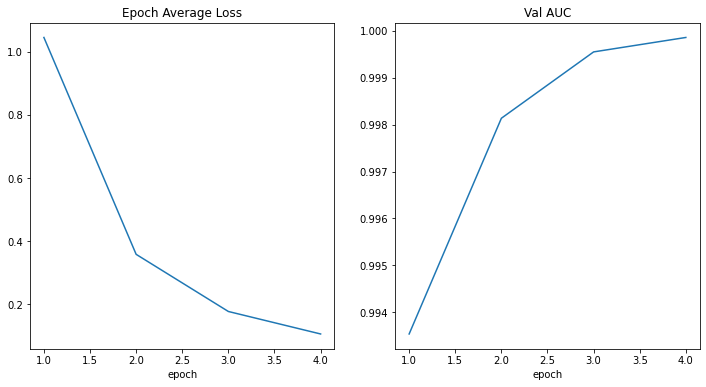

In [21]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate your model and understand the results
### Evaluate the model on the test dataset

After training and validation, we now have the best model as determined by the validation dataset. But now we need to evaluate the model on the test dataset to check whether the final model is robust and not over-fitting. We'll use these predictions to generate a classification report.

In [22]:
net.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = net(test_images).argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

### Some light analytics - classification report

We'll utilize scikit-learn's classification report to get the precision, recall, and f1-score for each category.

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9801    0.9840    0.9820      1000
   BreastMRI     0.9944    0.9933    0.9939       895
         CXR     0.9980    0.9840    0.9909      1000
     ChestCT     0.9960    1.0000    0.9980      1000
        Hand     0.9841    0.9890    0.9865      1000
      HeadCT     0.9830    0.9850    0.9840      1000

    accuracy                         0.9891      5895
   macro avg     0.9893    0.9892    0.9892      5895
weighted avg     0.9892    0.9891    0.9891      5895



### Some light analytics - confusion matrix

Let's also create a confusion matrix to get a better understanding of the failure cases

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


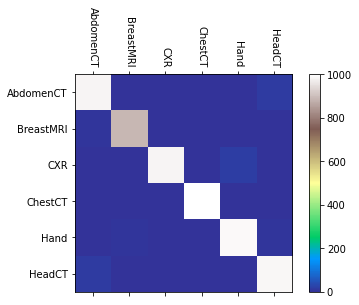

In [24]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_true, y_pred), cmap="terrain", interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+class_names, rotation=270)
ax.set_yticklabels(['']+class_names)

plt.show()

## Caution !!!
### please shutdown all kernels with [Kernel] menu >  [Shutdown All Kernel]  before launch next notebook

## Navigation
- [01_getting started](./01_getting.ipynb)

- [02_pipeline_01](./02_pipeline_01.ipynb)
- [02_pipeline_02](./02_pipeline_02.ipynb)
- [02_pipeline_03](./02_pipeline_03.ipynb)
- [02_pipeline_04](./02_pipeline_04.ipynb)

- [03_brain_gan Next ](./03_brain_gan_01.ipynb)

- [04_spleen_segment](./04_spleen_segment.ipynb) 

- [05_challenge_cardiac baseline](./05_challenge_cardiac_baseline.ipynb) 

- [05_challenge_cardiac workspace](./05_challenge_cardiac_workspace.ipynb) 

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>